# Agentic Customer Segmentation for Targeted Marketing
Build a segmentation pipeline and a local LLM-backed agent that explains clusters, retrieves grounding docs, and drafts targeted messages.

In [1]:
import numpy as np
import pandas as pd

def generate_insurance_dataset_realistic_v4(
    n_customers: int = 5000,
    start_date: str = "2020-01-01",
    end_date: str = "2024-12-31",
    seed: int = 42,
    correlation_strength: float = 0.6,
    return_metadata: bool = False,
    adaptive_noise: bool = True,
    base_std: float = 0.05,
    strength: float = 0.08
) -> pd.DataFrame:
    """
    Version 4 — Realistic Synthetic Insurance Dataset Generator with Adaptive Noise
    
    ✅ Enhancements over v3:
    - Integrated adaptive behavioral noise based on income and age
    - Slightly more realistic renewal/churn variation by customer profile
    - Optional automatic saving and metadata return
    """

    rng = np.random.default_rng(seed)
    correlation_strength = np.clip(correlation_strength, 0.0, 0.95)
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    # --- 1. Demographics (age–income correlation)
    mean = [0, 0]
    cov = [[1, correlation_strength], [correlation_strength, 1]]
    z_age, z_income = rng.multivariate_normal(mean, cov, n_customers).T

    ages = np.clip((z_age * 12 + 45).astype(int), 18, 85)
    income_levels = np.exp(z_income * 0.3) * (25000 + 600 * ages)
    income_levels *= rng.lognormal(0, 0.2, n_customers)
    income_levels = np.clip(income_levels, 20000, 250000)

    genders = rng.choice(["M", "F"], n_customers, p=[0.52, 0.48])
    regions = rng.choice(["Urban", "Suburban", "Rural"], n_customers, p=[0.4, 0.45, 0.15])

    # --- 2. Policy Type (income-driven probability)
    income_scaled = (income_levels - income_levels.min()) / (income_levels.max() - income_levels.min())
    policy_probs = np.vstack([
        np.clip([
            0.55 - 0.10 * income_scaled,
            0.25 + 0.10 * income_scaled,
            0.10 + 0.08 * income_scaled,
            np.full_like(income_scaled, 0.10)
        ], 0, None).T for _ in range(1)
    ]).reshape(n_customers, 4)
    policy_probs /= policy_probs.sum(axis=1, keepdims=True)
    policy_types = np.array(["Auto", "Home", "Life", "Health"])
    chosen_policy = [rng.choice(policy_types, p=p) for p in policy_probs]

    # --- 3. Premium Amounts (policy + income)
    base_premiums = {"Auto": 800, "Home": 1600, "Life": 2000, "Health": 1200}
    premium_base = np.array([base_premiums[p] for p in chosen_policy])
    premium_amount = premium_base * (1 + np.sqrt(income_levels / 150000) * 0.5)
    premium_amount *= rng.lognormal(0, 0.25, n_customers)
    premium_amount = np.clip(premium_amount, 300, 10000)

    # --- 4. Policy tenure
    tenure_months = np.clip(rng.exponential(30, n_customers), 3, 84)
    tenure_days = (tenure_months * 30).astype(int)
    valid_start_days = np.maximum(1, (end - start).days - tenure_days)
    start_offsets = rng.integers(0, valid_start_days, n_customers)
    policy_start_dates = start + pd.to_timedelta(start_offsets, unit="D")
    policy_end_dates = policy_start_dates + pd.to_timedelta(tenure_days, unit="D")
    policy_end_dates = policy_end_dates.where(policy_end_dates <= pd.Timestamp(end), pd.Timestamp(end))

    # --- 5. Payment behavior
    payment_freq = rng.choice(["Monthly", "Quarterly", "Annual"], n_customers, p=[0.6, 0.25, 0.15])
    payment_regularity = np.clip(rng.beta(4, 1.5, n_customers) + rng.normal(0, 0.05, n_customers), 0.3, 1.0)

    # --- 6. Claims (depends on age + policy)
    base_claim_rate = np.where(ages < 25, 0.25, np.where(ages > 65, 0.18, 0.1))
    policy_factor = np.array([{"Auto":1.4, "Home":0.8, "Life":0.6, "Health":1.0}[p] for p in chosen_policy])
    claim_lambda = base_claim_rate * policy_factor * np.sqrt(tenure_months / 12)
    num_claims = np.clip(rng.poisson(claim_lambda), 0, 15)

    # Claim costs — lognormal by policy type
    claim_cost_params = {"Auto": (7.8, 0.9), "Home": (8.3, 0.8), "Life": (9.0, 0.6), "Health": (8.0, 1.0)}
    claim_costs = np.zeros(n_customers)
    for p, (mean, sigma) in claim_cost_params.items():
        idx = np.array(chosen_policy) == p
        claim_costs[idx] = num_claims[idx] * rng.lognormal(mean, sigma, idx.sum())

    # --- 7. Renewal probability (with adaptive noise)
    logits = (
        -0.02 * (ages - 45)
        - 0.3 * num_claims
        + 1.0 * payment_regularity
        + 0.004 * tenure_months
        + rng.normal(0, 0.5, n_customers)
    )
    renewal_prob = 1 / (1 + np.exp(-logits))
    renewal_prob = np.clip(renewal_prob, 0.05, 0.95)

    # 🔹 Adaptive noise based on age & income
    if adaptive_noise:
        income_norm = (income_levels - income_levels.min()) / (income_levels.max() - income_levels.min())
        age_norm = (ages - ages.min()) / (ages.max() - ages.min())

        # Stable customers: older + higher income
        stability_score = (income_norm + age_norm) / 2
        noise_std = base_std + strength * (1 - stability_score)

        adaptive_noise = rng.normal(0, noise_std)
        renewal_prob = np.clip(renewal_prob + adaptive_noise, 0.01, 0.99)

    churned = rng.binomial(1, 1 - renewal_prob)

    # --- 8. Last claim date
    has_claims = num_claims > 0
    last_claim_date = np.full(n_customers, np.datetime64("NaT"), dtype="datetime64[ns]")
    random_offsets = rng.exponential(180, has_claims.sum()).astype(int)
    temp_dates = policy_end_dates[has_claims] - pd.to_timedelta(random_offsets, unit="D")
    temp_dates = np.maximum(temp_dates.values.astype("datetime64[D]"), policy_start_dates[has_claims].values.astype("datetime64[D]"))
    last_claim_date[has_claims] = temp_dates

    # --- 9. Lifetime Value (LTV)
    expected_value = premium_amount * (tenure_months / 12)
    claim_penalty = np.minimum(claim_costs / (expected_value + 1e-6), 0.8)
    ltv = expected_value * (1 - claim_penalty) * (0.8 + 0.4 * renewal_prob)
    ltv[churned == 1] *= rng.uniform(0.4, 0.8, churned.sum())
    ltv = np.clip(ltv, 0, 250_000)

    # --- 10. Derived temporal features
    policy_age_days = (policy_end_dates - policy_start_dates).days
    days_since_last_claim = (policy_end_dates - last_claim_date).days.astype(float).to_numpy()
    days_since_last_claim[~has_claims] = np.nan
    is_active = (policy_end_dates >= end).astype(int)

    # --- 11. Final DataFrame
    df = pd.DataFrame({
        "customer_id": [f"CUST_{i:05d}" for i in range(1, n_customers + 1)],
        "age": ages,
        "gender": genders,
        "region": regions,
        "income_level": np.round(income_levels, 2),
        "policy_type": chosen_policy,
        "premium_amount": np.round(premium_amount, 2),
        "payment_frequency": payment_freq,
        "payment_regularity": np.round(payment_regularity, 3),
        "tenure_months": np.round(tenure_months, 1),
        "num_claims": num_claims,
        "claim_costs": np.round(claim_costs, 2),
        "policy_start_date": policy_start_dates,
        "policy_end_date": policy_end_dates,
        "last_claim_date": pd.to_datetime(last_claim_date),
        "renewal_probability": np.round(renewal_prob, 3),
        "churned": churned,
        "customer_ltv": np.round(ltv, 2),
        "policy_age_days": policy_age_days,
        "days_since_last_claim": days_since_last_claim,
        "is_active": is_active,
    })

    if return_metadata:
        metadata = {
            "n_customers": n_customers,
            "start_date": start_date,
            "end_date": end_date,
            "seed": seed,
            "correlation_strength": correlation_strength,
            "adaptive_noise": adaptive_noise,
            "generated_on": pd.Timestamp.now().isoformat(),
        }
        return df, metadata

    return df


In [2]:
def augment_with_engagement_and_flags_v3(df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """
    ✅ Version 3 — Realistic augmentation of insurance dataset with engagement, delinquency, and risk flags.
    
    Key improvements:
    - No leakage from churn/renewal into behavior features.
    - Behavioral realism: digital users (younger, urban, higher income) show more engagement.
    - Payment and claim behaviors influence risk/delinquency flags probabilistically.
    - Adds derived scores and flags used for segmentation.
    """

    rng = np.random.default_rng(seed)
    df = df.copy()

    # --- 1. Engagement behavior (portal logins, calls, emails)
    # Digital affinity by region & age
    digital_affinity = (
        0.6 * (df["region"] == "Urban").astype(float)
        + 0.3 * (df["region"] == "Suburban").astype(float)
        + 0.1 * (df["region"] == "Rural").astype(float)
    )
    digital_affinity *= np.clip((70 - df["age"]) / 40, 0, 1)  # Younger = more digital
    digital_affinity *= np.clip(np.log1p(df["income_level"]) / np.log(150_000), 0.6, 1.2)

    # Engagement base (mean ~ digital_affinity × tenure)
    base_logins = 3 + 15 * digital_affinity + 0.05 * df["tenure_months"]
    portal_logins = np.clip(rng.normal(base_logins, 2), 0, None).astype(int)

    # Support calls (older + rural → more)
    support_calls = np.clip(
        rng.poisson(1 + 0.015 * (df["age"] - 30) + 1.5 * (df["region"] == "Rural").astype(int)),
        0,
        15,
    )

    # Emails opened (proportional to digital use)
    emails_opened = np.clip(rng.poisson(10 * digital_affinity + 2), 0, 50)

    # --- 2. Payment delinquency
    base_delinquency_prob = (
        0.04 + 0.08 * (df["payment_regularity"] < 0.8).astype(float)
        + 0.03 * (df["income_level"] < 40_000).astype(float)
        + 0.02 * (df["policy_type"] == "Auto").astype(float)
    )
    delinquency_count = rng.binomial(n=3, p=np.clip(base_delinquency_prob, 0, 0.8))

    # --- 3. Engagement score (normalized composite)
    max_portal, max_emails, max_calls = (
        portal_logins.max(),
        emails_opened.max(),
        support_calls.max(),
    )
    engagement_score = (
        0.5 * (portal_logins / (max_portal + 1e-5))
        + 0.3 * (emails_opened / (max_emails + 1e-5))
        + 0.2 * (1 - support_calls / (max_calls + 1e-5))
    )
    engagement_score = np.clip(engagement_score, 0, 1)

    # --- 4. Risk flags (no leakage)
    # High claim frequency/severity → high risk
    claim_freq_flag = (df["num_claims"] > 3).astype(int)
    high_claim_cost_flag = (df["claim_costs"] > df["claim_costs"].median() * 2).astype(int)

    # Financial risk from delinquency
    payment_risk_flag = (delinquency_count >= 2).astype(int)

    # Behavior risk (low engagement)
    low_engagement_flag = (engagement_score < 0.3).astype(int)

    # --- 5. Lifecycle and product mix
    # Simple heuristic: stage inferred from tenure
    lifecycle_stage = pd.cut(
        df["tenure_months"],
        bins=[0, 12, 36, 72, np.inf],
        labels=["New", "Growth", "Mature", "Legacy"],
        right=False,
    )

    # Product mix: probability of having another product (income + engagement)
    multi_policy_prob = np.clip(0.1 + 0.001 * (df["income_level"] / 1000) + 0.3 * engagement_score, 0, 0.9)
    multi_policy_flag = rng.binomial(1, multi_policy_prob)

    # --- 6. Engagement trends (rolling proxy)
    recent_logins_3m = np.clip(
        (portal_logins * rng.uniform(0.6, 1.0, len(df))).astype(int),
        0,
        portal_logins,
    )
    engagement_trend = np.where(
        recent_logins_3m > (0.8 * portal_logins), "Up",
        np.where(recent_logins_3m < (0.5 * portal_logins), "Down", "Stable")
    )

    # --- 7. Add all columns
    df["portal_logins"] = portal_logins
    df["support_calls"] = support_calls
    df["emails_opened"] = emails_opened
    df["delinquency_count"] = delinquency_count
    df["engagement_score"] = np.round(engagement_score, 3)
    df["claim_freq_flag"] = claim_freq_flag
    df["high_claim_cost_flag"] = high_claim_cost_flag
    df["payment_risk_flag"] = payment_risk_flag
    df["low_engagement_flag"] = low_engagement_flag
    df["multi_policy_flag"] = multi_policy_flag
    df["lifecycle_stage"] = lifecycle_stage
    df["engagement_trend"] = engagement_trend

    return df


#### Engagement & Behavioral Augmentation

In this step, we extend the core insurance dataset with behavioral and risk-oriented features.
The augmentation focuses on *realistic but non-leaky* signals that reflect how customers interact
with digital platforms, payment schedules, and policy services.

**Highlights**
- No target leakage from churn or renewal into engagement metrics.
- Behavioral realism: younger, urban customers are more digitally engaged.
- Risk flags derived from independent probabilistic logic.
- Added lifecycle and engagement trend indicators to support clustering.

We'll use these features to drive segmentation and interpret customer clusters
in later stages of the project.


In [3]:
import pandas as pd
import numpy as np
import random
import uuid
from datetime import timedelta
from textwrap import shorten

def generate_document_corpus_v2(
    customers_df: pd.DataFrame = None,
    n_docs: int = 60,
    start_date: str = "2020-01-01",
    end_date: str = "2024-12-31",
    seed: int = 42,
    verbose: bool = False,
    max_passage_words: int = 200,
) -> pd.DataFrame:
    """
    Generate a synthetic document corpus aligned with a customer/policy dataset.

    Features:
      - Optional linking to customers_df: attaches policy_id / customer_id where relevant
      - Category/subtype normalized across all docs
      - created_date sampled between start_date and end_date (can align to policy dates)
      - Topic-aware keywords and longer contextual text for better retrieval
      - Passage splitting (if text long) and stable doc_id / passage_id scheme
      - Returns DataFrame ready for embedding + indexing with metadata fields:
        ['doc_id', 'passage_id', 'policy_id', 'customer_id', 'category', 'subtype',
         'source', 'created_date', 'text', 'keywords']
    """
    np.random.seed(seed)
    random.seed(seed)

    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    total_days = max(1, (end - start).days)

    # --- Helper maps for realistic keyword selection
    kw_map = {
        "Auto": ["auto", "vehicle", "driver", "collision", "telematics", "premium"],
        "Home": ["home", "property", "dwelling", "flood", "fire", "repair", "inspection"],
        "Life": ["life", "beneficiary", "term", "payout", "underwriting", "medical"],
        "Health": ["health", "hospital", "claim", "copay", "provider", "network"],
        "General": ["renewal", "notice", "payment", "correspondence", "policy", "update"],
        "Underwriting": ["risk", "score", "medical", "credit", "assessment"],
        "CaseSummary": ["case", "resolution", "retention", "offer", "outcome"],
        "Product": ["product", "plan", "feature", "tier", "update", "launch"],
        "Marketing": ["campaign", "offer", "discount", "promotion", "customer", "communication"],
    }

    # --- Base templates (policy, underwriting, product, marketing, etc.)
    base_templates = [
        ("Auto", "Policy Wording",
         "This Auto policy includes comprehensive, collision and liability coverages. Deductibles and premium adjustments depend on driver age, claim history, and telematics scores. {extra}"),
        ("Home", "Policy Wording",
         "This Home policy covers dwelling, personal property and loss-of-use. Coverage limits and exclusions depend on construction type and local hazards. {extra}"),
        ("Life", "Policy Wording",
         "Term and whole-life options are available. Premiums and eligibility depend on medical underwriting and beneficiary designation. {extra}"),
        ("Health", "Policy Wording",
         "Tiered health plans (Bronze/Silver/Gold) with varying provider networks and out-of-pocket limits. Pre-authorization required for selected services. {extra}"),

        ("General", "Renewal Notice",
         "Your policy is due for renewal on {policy_end_date}. Please review updated premium and coverage information. {extra}"),
        ("General", "Premium Notice",
         "We are notifying you of a premium change effective {effective_date} due to regional claim trends. {extra}"),
        ("Underwriting", "Underwriting Note",
         "Underwriting analysis: risk factors include {risk_factors}. Recommends class change: {recommendation}. {extra}"),
        ("CaseSummary", "Retention Case",
         "Case summary: Customer was at risk due to recent claims; retention offer included a targeted discount and service outreach. Outcome: {outcome}. {extra}"),
        ("Product", "Product Update",
         "Product update: New telematics discount launched. Eligible customers will receive communication and opt-in instructions. {extra}"),
        ("General", "Claim Update",
         "Claim {claim_ref} is being processed. Current status: {status}. Estimated settlement: {estimate}. {extra}"),
    ]

    # --- Add new content types: Product Brochures & Campaign Templates
    base_templates.extend([
        ("Product", "Brochure",
         "Introducing our {policy_type} insurance plan — designed to provide better protection and flexible coverage options. Key highlights include: {highlights}. Learn how you can save with telematics and bundled discounts. {extra}"),
        ("Product", "Product Overview",
         "Our latest {policy_type} policy offers enhanced benefits, simplified claims, and faster online servicing. Whether you’re a new or existing customer, this plan helps you manage your coverage efficiently. {extra}"),
        ("Marketing", "Campaign Template",
         "Subject: {subject}\n\nDear customer, we’re excited to announce our new {policy_type} plan. {benefit_statement}. Don’t miss this opportunity — apply by {deadline}. {cta}"),
        ("Marketing", "Email Campaign",
         "Get rewarded for staying protected! Our loyalty campaign offers up to 15% off renewals on select {policy_type} policies. {extra} Join thousands who already switched and saved."),
    ])

    # --- Prepare synthetic linking to customers/policies if available
    if customers_df is not None and "policy_type" in customers_df.columns:
        customers_df = customers_df.copy()
        if "policy_id" not in customers_df.columns:
            customers_df["policy_id"] = [f"P{100000 + i}" for i in range(len(customers_df))]
        policy_links = customers_df[["customer_id", "policy_id", "policy_type", "policy_start_date", "policy_end_date"]].to_dict("records")
    else:
        policy_links = [{"customer_id": None, "policy_id": None, "policy_type": random.choice(["Auto","Home","Life","Health"]),
                         "policy_start_date": start + timedelta(days=random.randint(0, total_days//2)),
                         "policy_end_date": start + timedelta(days=random.randint(total_days//2, total_days))} for _ in range(200)]

    # --- Instantiate docs
    all_docs = []
    for (category, subtype, template) in base_templates:
        for _ in range(3):  # multiple variants per template
            extra_phrases = [
                "This language was updated to reflect regulatory guidance.",
                "This clause applies only to new business issued within the last 12 months.",
                "Refer to underwriting manual section 4.2 for scoring rules.",
                "This summary reflects the current version of the product.",
            ]
            extra = random.choice(extra_phrases)

            safe_kwargs = dict(
                extra=extra,
                policy_type=random.choice(["Auto", "Home", "Life", "Health"]),
                policy_end_date="2024-12-31",
                effective_date="2024-01-01",
                risk_factors="driver age, credit score",
                recommendation="standard",
                outcome="retained",
                claim_ref=f"CLM{random.randint(10000,99999)}",
                status="in progress",
                estimate="$1500",
                highlights=random.choice([
                    "customizable deductibles, multi-policy savings, and digital servicing tools",
                    "expanded coverage for extreme weather events and enhanced roadside assistance",
                    "wellness rewards and lower premiums for safe drivers",
                ]),
                subject=random.choice([
                    "Save More with Our New Plan!",
                    "Exclusive Renewal Offer Inside",
                    "Your Coverage, Upgraded",
                ]),
                benefit_statement=random.choice([
                    "Enjoy lower premiums and smarter coverage options tailored to your needs",
                    "Upgrade to enhanced protection with minimal paperwork",
                    "Protect what matters most with our simplified digital policies",
                ]),
                deadline=random.choice(["June 30", "September 1", "December 31"]),
                cta=random.choice(["Click here to learn more.", "Enroll today!", "Get your personalized quote now."]),
            )

            body = template.format(**safe_kwargs)
            all_docs.append({"category": category, "subtype": subtype, "text": body})

    # --- Expand if fewer than n_docs
    while len(all_docs) < n_docs:
        sample = random.choice(all_docs)
        variation = sample.copy()
        rev = random.randint(1, 5)
        change = random.choice(["Updated rates", "Coverage change", "New clause added", "Review summary", "Clarified exclusions"])
        variation["text"] = f"{variation['text']} (Revision {rev}: {change})."
        all_docs.append(variation)

    # --- Balanced sampling
    if len(all_docs) > n_docs:
        categories = list(set([d["category"] for d in all_docs]))
        chosen = []
        for c in categories:
            candidates = [d for d in all_docs if d["category"] == c]
            chosen.append(random.choice(candidates))
        remaining = n_docs - len(chosen)
        others = [d for d in all_docs if d not in chosen]
        chosen.extend(random.sample(others, remaining))
        all_docs = chosen

    # --- Build final corpus with metadata and passage splitting
    corpus = []
    for i, doc in enumerate(all_docs, start=1):
        uid = uuid.uuid4().hex[:8].upper()
        doc_id = f"DOC_{uid}"
        link = random.choice(policy_links)
        linked_policy = link["policy_id"] if random.random() < 0.4 else None
        linked_customer = link["customer_id"] if linked_policy is not None else None

        if linked_policy and link.get("policy_start_date") is not None and link.get("policy_end_date") is not None:
            p_start = pd.to_datetime(link["policy_start_date"])
            p_end = pd.to_datetime(link["policy_end_date"])
            if pd.isna(p_start) or pd.isna(p_end) or p_end <= p_start:
                created_date = start + timedelta(days=random.randint(0, total_days))
            else:
                created_date = p_start + timedelta(days=random.randint(0, max(1, (p_end - p_start).days)))
        else:
            created_date = start + timedelta(days=random.randint(0, total_days))

        source = "internal" if doc["subtype"] in ("Underwriting Note", "Agent Note", "CaseSummary") else random.choice(["customer-facing", "internal", "agent-note"])
        kw_pool = kw_map.get(doc["category"], kw_map["General"])
        keywords = random.sample(kw_pool, k=min(len(kw_pool), random.randint(3, 5)))

        context_sentences = [
            "This excerpt summarizes the key points relevant to pricing and retention.",
            "Please refer to the full policy for exact conditions and exclusions.",
            "Contact the underwriting or marketing team for clarifications.",
            "This note was generated as part of an automated review process."
        ]
        text = doc["text"] + " " + " ".join(random.sample(context_sentences, k=random.randint(1, 2)))
        text = shorten(text, width=800, placeholder=" ...")

        words = text.split()
        passages = [text] if len(words) <= max_passage_words else [
            " ".join(words[i:i+max_passage_words]) for i in range(0, len(words), max_passage_words)
        ]

        for p_idx, passage in enumerate(passages, start=1):
            passage_id = f"{doc_id}_P{p_idx:02d}"
            corpus.append({
                "doc_id": doc_id,
                "passage_id": passage_id,
                "policy_id": linked_policy,
                "customer_id": linked_customer,
                "category": doc["category"],
                "subtype": doc["subtype"],
                "source": source,
                "created_date": created_date,
                "created_date_str": created_date.strftime("%Y-%m-%d"),
                "text": passage,
                "keywords": keywords,
            })

    corpus_df = pd.DataFrame(corpus)

    if verbose:
        print(f"✅ Generated document corpus: {len(corpus_df)} passages from {len(all_docs)} docs")
        print(f"Categories: {sorted(corpus_df['category'].unique().tolist())}")
        print("Example passage metadata:")
        print(corpus_df.iloc[0].to_dict())

    return corpus_df


# 1. Data Exploration & Preprocessing
## 1.1 Examine the Data

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display

# --- Generate a dataset (small for quick runs; change n_customers for full run)
df = generate_insurance_dataset_realistic_v4(n_customers=5000, seed=42)
df = augment_with_engagement_and_flags_v3(df, seed=42)

# Generate document corpus linked (verbosity off)
corpus = generate_document_corpus_v2(customers_df=df, n_docs=120, seed=42, verbose=False)

# Quick peek
print("Customers shape:", df.shape)
display(df.head())
print("Corpus passages:", corpus.shape)
display(corpus.head())


Customers shape: (5000, 33)


,customer_id,age,gender,region,income_level,policy_type,premium_amount,payment_frequency,payment_regularity,tenure_months,...,emails_opened,delinquency_count,engagement_score,claim_freq_flag,high_claim_cost_flag,payment_risk_flag,low_engagement_flag,multi_policy_flag,lifecycle_stage,engagement_trend
0,CUST_00001,47,F,Suburban,44168.91,Auto,1122.52,Monthly,0.885,44.3,...,8,0,0.536,0,0,0,0,1,Mature,Stable
1,CUST_00002,31,M,Urban,48409.92,Auto,802.03,Monthly,0.565,47.5,...,9,0,0.636,0,0,0,0,0,Mature,Stable
2,CUST_00003,72,F,Rural,72009.81,Auto,1189.47,Monthly,0.419,28.4,...,2,1,0.372,0,0,0,0,0,Growth,Stable
3,CUST_00004,45,M,Suburban,45488.18,Health,1463.59,Quarterly,0.798,3.0,...,2,0,0.408,0,0,0,0,0,New,Stable
4,CUST_00005,49,M,Suburban,57527.04,Auto,1300.48,Monthly,0.758,46.0,...,5,1,0.327,0,0,0,0,0,Mature,Stable


Corpus passages: (120, 11)


,doc_id,passage_id,policy_id,customer_id,category,subtype,source,created_date,created_date_str,text,keywords
0,DOC_65470FC4,DOC_65470FC4_P01,None,None,Auto,Policy Wording,agent-note,2024-01-13,2024-01-13,"This Auto policy includes comprehensive, colli...","[telematics, collision, vehicle, driver]"
1,DOC_6FBA2A38,DOC_6FBA2A38_P01,None,None,Auto,Policy Wording,agent-note,2021-07-21,2021-07-21,"This Auto policy includes comprehensive, colli...","[premium, vehicle, driver, telematics]"
2,DOC_6320FAB3,DOC_6320FAB3_P01,P101920,CUST_01921,Auto,Policy Wording,agent-note,2022-09-27,2022-09-27,"This Auto policy includes comprehensive, colli...","[vehicle, premium, telematics]"
3,DOC_2993CBCF,DOC_2993CBCF_P01,P101752,CUST_01753,Home,Policy Wording,internal,2022-04-14,2022-04-14,"This Home policy covers dwelling, personal pro...","[flood, inspection, home, property, repair]"
4,DOC_0DBB3133,DOC_0DBB3133_P01,None,None,Home,Policy Wording,internal,2021-12-21,2021-12-21,"This Home policy covers dwelling, personal pro...","[inspection, flood, fire, property]"


### 1.1.1 Summary statistics & distribution checks

In [5]:
numeric_cols = [
    "age", "income_level", "premium_amount", "tenure_months",
    "num_claims", "claim_costs", "customer_ltv", "engagement_score",
]
display(df[numeric_cols].describe().T)

# Show counts for key categoricals
print("\nPolicy types:")
display(df['policy_type'].value_counts())

print("\nPayment frequency:")
display(df['payment_frequency'].value_counts())

print("\nLifecycle stage distribution:")
display(df['lifecycle_stage'].value_counts())


,count,mean,std,min,25%,50%,75%,max
age,5000.0,44.726400,11.878963,18.00,37.0000,45.000,53.0000,85.00
income_level,5000.0,56657.946920,26336.906642,20000.00,38308.7775,51322.915,68674.2050,235138.71
premium_amount,5000.0,1598.836752,747.142273,430.24,1016.8500,1382.075,2040.2150,6095.43
tenure_months,5000.0,28.781720,24.266744,3.00,8.9000,21.200,42.3250,84.00
num_claims,5000.0,0.176200,0.433118,0.00,0.0000,0.000,0.0000,4.00
claim_costs,5000.0,793.755008,2910.710586,0.00,0.0000,0.000,0.0000,70138.98
customer_ltv,5000.0,3239.060500,3793.751710,25.40,682.0000,1879.755,4331.9450,33648.02
engagement_score,5000.0,0.440215,0.118815,0.08,0.3580,0.432,0.5195,0.90



Policy types:


policy_type
Auto      2606
Home      1319
Life       593
Health     482
Name: count, dtype: int64


Payment frequency:


payment_frequency
Monthly      3061
Quarterly    1232
Annual        707
Name: count, dtype: int64


Lifecycle stage distribution:


lifecycle_stage
Growth    1835
New       1613
Mature    1083
Legacy     469
Name: count, dtype: int64

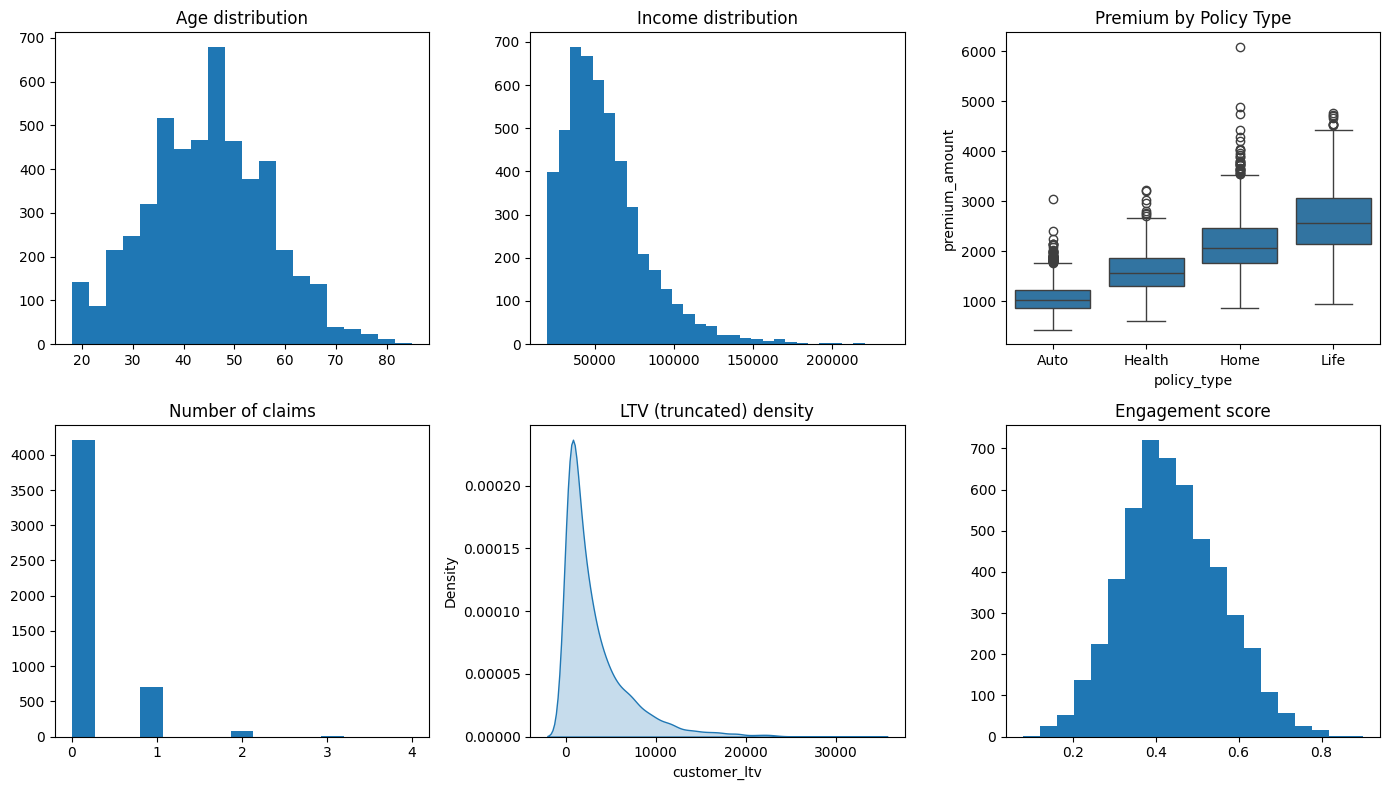

In [6]:
plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.hist(df['age'], bins=20)
plt.title("Age distribution")

plt.subplot(2,3,2)
plt.hist(df['income_level'], bins=30)
plt.title("Income distribution")

plt.subplot(2,3,3)
sns.boxplot(x='policy_type', y='premium_amount', data=df)
plt.title("Premium by Policy Type")

plt.subplot(2,3,4)
plt.hist(df['num_claims'], bins=15)
plt.title("Number of claims")

plt.subplot(2,3,5)
sns.kdeplot(df['customer_ltv'].clip(0, 50000), fill=True)
plt.title("LTV (truncated) density")

plt.subplot(2,3,6)
plt.hist(df['engagement_score'], bins=20)
plt.title("Engagement score")

plt.tight_layout()
plt.show()


,tenure_bucket,n_customers,churn_rate,renewal_prob_mean
0,0-6,897,0.348941,0.658134
1,6-12,724,0.335635,0.662610
2,12-24,1086,0.333333,0.662697
3,24-48,1256,0.318471,0.673552
4,48+,1037,0.309547,0.700614


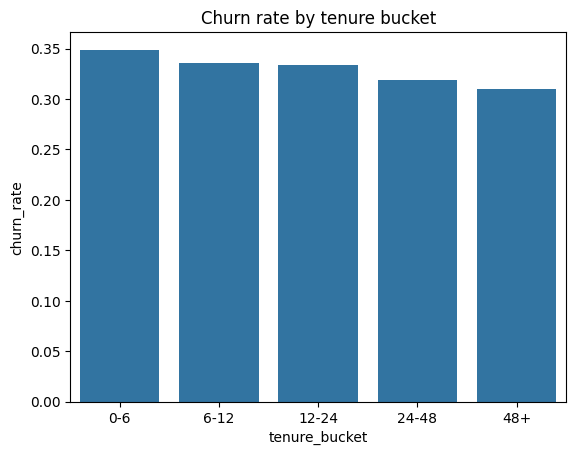

In [7]:
# Retention / churn curve — churn by tenure bucket
df['tenure_bucket'] = pd.cut(df['tenure_months'], bins=[0,6,12,24,48,1000], labels=["0-6","6-12","12-24","24-48","48+"])
ret = df.groupby('tenure_bucket').agg(
    n_customers=('customer_id','count'),
    churn_rate=('churned','mean'),
    renewal_prob_mean=('renewal_probability','mean')
).reset_index()
display(ret)
sns.barplot(x='tenure_bucket', y='churn_rate', data=ret)
plt.title("Churn rate by tenure bucket")
plt.show()


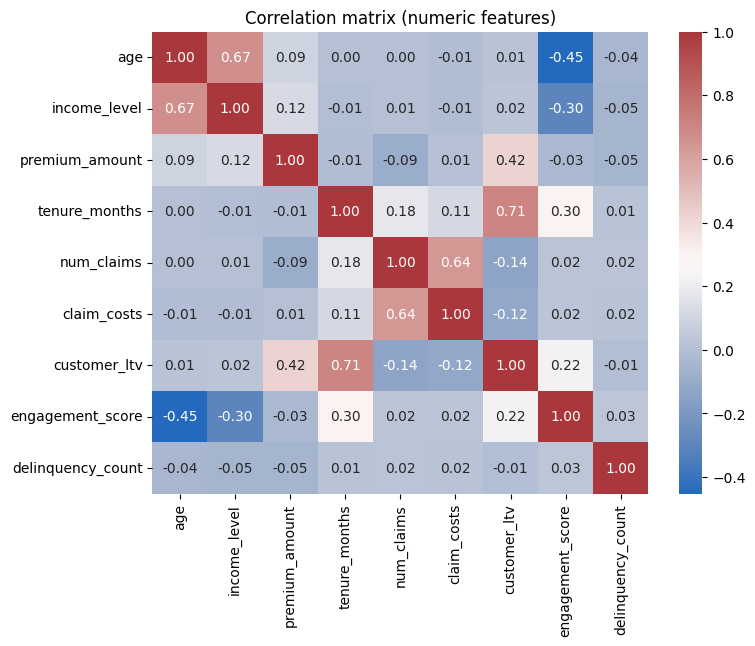

In [8]:
# Quick correlations (for numeric features)
corr = df[numeric_cols + ['delinquency_count']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation matrix (numeric features)")
plt.show()


In [9]:
# Sample a few corpus passages for manual inspection
for i, row in corpus.sample(5, random_state=42).iterrows():
    print(f"--- Passage {row['passage_id']} ({row['category']} / {row['subtype']}) ---")
    print(row['text'][:800])
    print()


--- Passage DOC_6CC020F2_P01 (Life / Policy Wording) ---
Term and whole-life options are available. Premiums and eligibility depend on medical underwriting and beneficiary designation. Refer to underwriting manual section 4.2 for scoring rules. (Revision 3: Updated rates). Please refer to the full policy for exact conditions and exclusions. This excerpt summarizes the key points relevant to pricing and retention.

--- Passage DOC_212DE722_P01 (General / Premium Notice) ---
We are notifying you of a premium change effective 2024-01-01 due to regional claim trends. This summary reflects the current version of the product. (Revision 3: New clause added). (Revision 3: Clarified exclusions). This note was generated as part of an automated review process. This excerpt summarizes the key points relevant to pricing and retention.

--- Passage DOC_0DBB3133_P01 (Home / Policy Wording) ---
This Home policy covers dwelling, personal property and loss-of-use. Coverage limits and exclusions depend o

In [10]:
# Save intermediate artifacts
df.to_parquet("data/raw_customers.parquet", index=False)
corpus.to_parquet("data/raw_corpus_passages.parquet", index=False)
